# Assignment #3 - Reinforcement Learning

### <font color="red"> DUE: Nov 1 (Thursday) 11:00 pm </font>  

<font color="blue"> Benjamin Daniel Poole </font>

# I. Overview

The goal of this assignment is to use the Q-learning or SARSA algorithms to find a path through a maze to a goal node and play a simple game of one-card Poker. The core idea of these algorithms is to repeatedly update the Q-values of the environment until the agent can optimally navigate to the goal node or win consistently in a game of Poker. Alongside of this, I want to see how changing different parameters affects the agents learning.

# II. Problems 

## A. Maze Problem (Practice)

The maze problem works by defining some maze-like environment where an agent must learn to reach some goal within said maze. In the GridWrold maze problem the maze is represented by a 2d array where every node is filled with the letters *O*, *H* and *G*. The letter *O* represents the locations the agent can move to. The letter *H* represents an impassable location, a location the agent can't move to. The letter *G* represents the goal location, where the agent wants to end up at. Overtime the agent should try different paths and learn from its mistake until it finally develops the best path to the goal node *G*. <br>

The environment dynamics are relatively simple with two major rules. First, if the agent moves off the grid then it receives a negative reward and is moved back to its previous location. Second, if the agent moves into an obstacle it receives a negative reward and is moved back to its previous location.

In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [2]:
%%bash 
cat grid.txt

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO

### GridWorld Class

Below is the code regarding the GridWorld environment dynamics.

In [3]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [4]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [5]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

## B. One-Card Poker  

The One-Card Poker game works just like Poker but now we are simply using 1 card. As the name entails, players receive one card and the highest card wins. There is one player agent (the agent I am training) and as many computer players as I would like to add. Every round the agent must make a bet based on its card, the total pot, the current bet and the other players' balances (this is the state information). The agents actions are based on the state environment 0,1,2,3 with 1-3 representing how much to bet and 0 meaning no bet or folding. It is important to note the player agent tries to learn the optimal actions based on the state information while the computer agent has a scripted policy.

The environment dynamics for the poker problem are a little more complex than the gridworld problem. Poker works by taking rounds where each player must bet based on the state information. Players must also match other players bets or fold. The goal of the player agent is to maximize its balance and therefore win the game through playing consecutive rounds. The poker game ends when no players, but one, has any money left (0 balance for all players but one).

![](http://www.poker-vibe.com/poker/terms/case-card/Case-Card.jpg)

<font color="red"> Game Introduction and Rules: </font>
1. This is a 1-card poker game. Where each player can blindly bet from 0 (fold), 1, 2 or 3 in the first round. In the next round only the player who havent matched the max amount( from all the players) will be given a chance to bet additional amount to match or fold. 


2. Each player will be able to see his/her own card and the total pot balance and all other player's balance and their current bet on for the round i.e this is what you can call the current state of the game. <br>

    a. <font color="red"> Example1 </font>: 3 players in game i.e. player1, computer1, computer2. First round, player1        bets 3, computer1 bets 2 and computer2 bets 1. Next round only computer1 and computer2 will be given a chance          to match the bet as player1 has max bet so computer1's available actions will be (0, 1) and computer2's                available actions will be (0, 2).<br>
    
    b. After they match or fold the result will be given. <br>
    
    c. This case is applicable for player1 being the one who needs to match. <font color="red"> Example2 </font>: 3          players in game i.e player1, computer1, computer2. First round, player1 bets 1, computer1 bets 2 and                  computer2 bets 3. Next round only player1 and computer1 will have chance to bet and match or fold. <br>
       
    d. The examples described above will be 1 round each, this will continue until player1 losses all the money or            computer1 and computer2 will be out of money. <br>
    
This is a local version of the game, your final competition if you decide to participate will be hosted on server. The local version, you can add multiple computer players in the game but only single agent.

This way you can train your agent to play against 1,2,3,4 


## One-Card Poker Environment

Below is the code for the Poker game.

In [6]:
import copy
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
def draw_card():
    return deck[np.random.randint(1, 13)]

In [7]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10, is_computer = 0)
        Above declaration will be for your agent. Only one non-computer
        player allowed in the local poker instance.
        However, you can create as many as you want computer_players 
        (test for 3 players but you can try more) i.e
        computer = Player("computer", start_balance = 10, is_computer = 1).
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10, is_computer = 0):
        self.player_name = player_name
        self.card = None
        self.total_balance = start_balance
        self.current_bet = 0
        self.is_computer = is_computer
        self.is_active = 0
        self.number_of_turn = 0
        self.match_bet = False
    
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance))
        print("Player is_active: {}".format(self.is_active))
        

In [37]:
class Poker():
    """
        Poker class will be the environment. 
        Important functions for users:
        1. Init Poker class i.e poker = Poker(number_of_player = 2)
           <Please dont add more than the number you declare here)
        2. add_player(player1) - adds player1 object to the game.
        3. get_current_state - gets the current state of the env
           {'other_stats': [[9, 1] ,[9, 1]], 'total_pot_balance': 2, 'player_stats': [6, 9, 1]}
           other_stats will contain the opponent information's balance and their current bet
           total_pot_balance will have total bet played by all players
           player_stats will contain player_card, player total balance, player current bet
        4. get_valid_actions -  returns the valid action available for the player
           based on balance and which round the player is in. You should take actions
           based on the return value.
           
    
    """
    def __init__(self, number_of_player = 2):
        self.all_players = []
        self.total_players = number_of_player
        self.total_pot_balance = 0
        self.player = None
        self.actions = [0, 1, 2, 3]
        self.number_of_turn = 0
        self.max_bet = 0
        
    def add_player(self, player_class):
        if player_class not in self.all_players and self.total_players > 0:
            self.all_players.append(player_class)
            self.total_players -= 1
            if player_class.is_computer == 0:
                if self.player == None:
                    self.player = player_class
                else:
                    raise Exception("Will override current player ! Only one non-computer player allowed !")
        else:
            raise Exception("Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(len(self.all_players)))
    
    def check_and_remove_players(self):
        player_remove, game_end = [], False
        for _player in self.all_players:
            if _player.total_balance <= 1:
                player_remove.append(_player)
        if len(player_remove) > 0:
            if self.player not in player_remove:
                for player in player_remove:
                    #print("Removing player: {} due to insufficient funds !!".format(player.player_name))
                    self.all_players.remove(player)                    
            else:
                #print("Player doesnt have balance !")
                game_end = True
                
                
    def deal(self):
        reset_game = False
        self.total_pot_balance = 0
        self.number_of_turn = 0
        
        if self.check_and_remove_players():
            reset_game = True
        else:
            if len(self.all_players) == 1:
                reset_game = True
            else:
                for _player in self.all_players:
                    if _player.total_balance > 1:
                        _player.card = draw_card()
                        _player.total_balance -= 1
                        _player.current_bet = 1
                        _player.is_active = 1
                        _player.number_of_turn = 0
                        _player.match_bet = False
                        self.total_pot_balance += 1
                        self.max_bet = 0
                    else:
                        #print("{} can no longer play the game !".format(_player.player_name))
                        reset_game = True        
        return reset_game
        
    def get_current_state(self):
        current_state_dict = {}
        current_state_dict['other_stats'] = [[_player.total_balance,_player.current_bet] for _player in self.all_players if _player != self.player]
        current_state_dict['total_pot_balance'] = self.total_pot_balance
        current_state_dict['player_stats'] = [self.player.card, self.player.total_balance, self.player.current_bet]
        return current_state_dict
    
    def get_valid_actions(self, player_name):
        list_player = [_player for _player in self.all_players if _player.player_name == player_name]
        if len(list_player) == 1:
            player = list_player[0] 
            if player.number_of_turn == 0:
                if player.total_balance > 3:
                    actions =  [0, 1, 2, 3]
                elif player.total_balance <= 3:
                    if player.total_balance <= 1:
                        actions = [0]
                    elif player.total_balance > 1 and player.total_balance <= 2:
                        actions =  [0, 1]
                    else:
                        actions = [0, 1, 2]
            else:
                possible_max_bet = player.total_balance - (self.max_bet - (player.current_bet - 1))
                if possible_max_bet >= 2:
                    actions = [0, self.max_bet - (player.current_bet - 1)]
                else:
                    actions = [0]                        
            return actions
        else:
            raise Exception("Invalid player name! Use the player name defined while initialzing the environment")
    
    def print_actions(self, player, action):
        #if action == 0:
            #print("{} folds".format(player))
        #else:
            #print("{} plays {}.".format(player, action))
        pass
            
    def computer_play(self):
        list_player = [_player for _player in self.all_players if _player.player_name != self.player.player_name and _player.is_active == 1 and _player.match_bet == False]
        for player in list_player:
            actions_available =  self.get_valid_actions(player.player_name)   
            #print("Available actions for: {} are {}".format(player.player_name, actions_available))
            action_taken = actions_available[np.random.randint(len(actions_available))]
            self.print_actions(player.player_name, action_taken)
            if self.max_bet == 0 and action_taken != 0 or self.max_bet < action_taken:
                self.max_bet = action_taken
            self.take_action(player.player_name, action_taken)
    
    def get_player(self, player_name):
        return_player = [player for player in self.all_players if player.player_name == player_name]
        if len(return_player) != 1:
            #print("Invalid Player")
            return None
        else:
            return return_player[0]
        
    def take_action(self, player_name, action_taken):
        player = self.get_player(player_name)
        player.number_of_turn += 1
        if action_taken != 0:
            player.total_balance -= action_taken
            player.current_bet += action_taken
            self.total_pot_balance += action_taken
            player.is_active = 1
        else:
            player.is_active = 0
            
    def check_game(self):
        game_over = True
        if np.sum([_player.is_active for _player in self.all_players if _player != self.player]) > 0:
            game_over = False
        return game_over
     
    def return_winner(self, players):
        max_card = np.max([_player.card for _player in players])
        return [_player for _player in players if _player.card == max_card]
            

    def settle_balance(self, winner):
        reward = 0
        if winner == "draw":
            active_player = [_player for _player in self.all_players if _player.is_active]
            if len(active_player) == 0:
                #print("Active player cards: {}".format([(_player.player_name, _player.card) for _player in self.all_players]))
                winning_players = self.all_players
            else:
                #print("Active player cards: {}".format([(_player.player_name, _player.card) for _player in self.all_players if _player.is_active]))
                winning_players = self.return_winner(active_player)
                
            per_player_share = self.total_pot_balance / len(winning_players)
            for _player in winning_players:
                _player.total_balance += per_player_share
            if self.player in winning_players:
                reward = per_player_share
            else:
                reward = -self.player.current_bet
            
                
        if winner == "player":
            self.player.total_balance += self.total_pot_balance
            reward = self.total_pot_balance
            winning_players = [self.player]
            
        if winner == "computer":
            active_player = [_player for _player in self.all_players if _player != self.player and _player.is_active]
            winning_players = self.return_winner(active_player)
            per_player_share = self.total_pot_balance / len(winning_players)
            for _player in winning_players:
                _player.total_balance += per_player_share
            reward = -self.player.current_bet
            
        #print("Printing winning players: {}".format(' '.join([player.player_name for player in winning_players])))
        #print("Reward : {}".format(reward))
        return reward
        
    def check_game_return_reward(self, round_num):
       # print("Check results for Round Number: {}".format(round_num))
        if self.check_game() and self.player.is_active == 0:
            #print("Computer folds, Player folds !")
            game_over = True
            winner = "draw"
            reward = 0
            return game_over, reward, winner 
        
        elif self.check_game() and self.player.is_active:
            #print("Computer folds, Player active !")
            game_over = True
            reward = self.total_pot_balance
            winner = "player"
            return game_over, reward, winner 
        
        elif not self.check_game() and self.player.is_active == 0:
            #print("Computer active, Player folds !")
            game_over = True
            reward = -self.player.current_bet
            winner = "computer"
            return game_over, reward, winner 

        if round_num == 1:
            #print("Computer active, Player active ! ")
            game_over = False
            reward = 0
            winner = "draw"
            return game_over, reward, winner 
        
        else:
            #print("Computer active, Player active in Round 2 ! End game now !")
            game_over = True
            active_players = [player for player in self.all_players if player.is_active]
            #print("Active player cards: {}".format([(_player.player_name, _player.card) for _player in active_players]))
            winning_players = self.return_winner(active_players)
            if self.player in winning_players:
                if len(winning_players) > 1:
                    reward = self.total_pot_balance / len(winning_players)
                    winner = "draw"
                else:
                    reward = self.total_pot_balance
                    winner = "player"
            else:
                reward = -self.player.current_bet
                winner = "computer"

            return game_over, reward, winner 
            

    
    def update_match(self):
        for player in [player for player in self.all_players if player.current_bet - 1 == self.max_bet]:
            player.match_bet = True
    
    def check_computer_status(self):
        computer_play = False
        if len([player for player in self.all_players if player.is_computer == 1 and player.match_bet == False and player.is_active == 1]) > 0:
            computer_play = True
        return computer_play
    
    def player_play(self, player_name, action_taken):
        game_over = False
        reward = 0  
        winner = None
        self.number_of_turn += 1
        
        if self.number_of_turn == 1:
            if self.max_bet == 0 and action_taken != 0 or self.max_bet < action_taken:
                self.max_bet = action_taken
            self.print_actions(player_name, action_taken)
            self.computer_play()
            self.take_action(player_name, action_taken)
            self.update_match()
            if self.player.is_active:
                if self.player.match_bet and not self.check_computer_status():
                    #print("Player and Computer both Bet Max and match !")
                    _, reward, winner = self.check_game_return_reward(round_num=1)
                    game_over = True
            else:
                if self.check_computer_status():
                    #print("Player folds, computer players are active, they will play among themselves !")
                    self.computer_play()
                game_over, reward, winner = self.check_game_return_reward(round_num=1)
                
            if game_over:
                #print("Winner: {}".format(winner))
                new_reward = self.settle_balance(winner)
                if winner == "draw":
                    reward = new_reward
            else:
                if self.player.match_bet and self.check_computer_status():
                    #print("Player Bet Max, computer will match now !")
                    self.computer_play()
                    game_over, reward, winner = self.check_game_return_reward(round_num=2)
                    #print("Winner: {}".format(winner))
                    new_reward = self.settle_balance(winner)
                    if winner == "draw":
                        reward = new_reward
                    
            return self.get_current_state(), reward, game_over
        
        if self.number_of_turn == 2:
            self.print_actions(player_name, action_taken)
            self.take_action(player_name, action_taken)
            if self.check_computer_status():
                self.computer_play()
            game_over = True
            _, reward, winner = self.check_game_return_reward(round_num=2)
            #print("Winner: {}".format(winner))
            new_reward = self.settle_balance(winner)
            if winner == "draw":
                reward = new_reward
        
        return self.get_current_state(), reward, game_over
    
    
        

# III. Methods

### Explanation of RLAgent (Grid and Poker) code

#### Training with SARSA, and Q-learning  
- The first function is the train() function. This function is where the agent utilizes a host of parameters and the famous SARSA or Q-learning algorithms. I will be utilizing Q-learning due to its off-policy behavior but let me explain how both SARSA and Q-learning work. Both algorithms work by a taking a one-step look ahead which finds the next state-action value and utilizes this next state-action value as a target. Therefore, both algorithms utilize TD error (reward + next state-action value - current state-action value). The main difference is that Q-learning doesn’t base its one-step look ahead on the policy, it picks the maximum next state-action value as the target (off-policy = s_t+1, a). On the other hand, SARSA bases its one-step look ahead on the current policy and picks the next state-action value in the policy as the target (on-policy = s_t+1, a_t+1). Both of these algorithms sever as updates to the Q-table which is the main functionality of the train() function, Q-table updates are equivalent to learning. Below are the update functions for SARSA and Q-learning. Since Q-table updates are the main focus of the train() function the rest of the code in the train() function focuses on grabbing the current state and action while also utilizing epsilon greedy to balance exploration vs exploitation when picking an action.

####  Answer to TODO question
 - The answer to the question bellow, "Why is this zero?", is a rather simple. The next state and action after the goal node is 0 because there are no more next states or actions after the goal. Therefore, we set the next state and action values to 0 to account for the episode ending and no further reward can be earned, along with no futher Q-value updates.

#### Why I chose Q-Learning

 - As I previously mentioned I decided to go with Q-learning due to its off-policy learning. Q-learning tends to find the optimal policy and has a rather simple convergence, all that is required is that all state-action pairs are continuously updated. From what I have read and seen Q-learning seems to provide a deeper robustness to learning and is commonly used in today’s research, therefore, I chose Q-learning.<br>
    
**SARSA Update**
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

**Q-Learning Update**
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

#### E-greedy and Testing

- The second function is the epsilon_greed() function, mentioned above. The epsilon_greed() function works by randomly taking actions based on the parameter epsilon. If epsilon is equal to .2 then there is a 20% chance for a random action to be selected. Otherwise the algorithm choses a greedy action, defined by taking the maximal Q-value. Below is how the epsilon_greed() function selects its actions greedly.

$$
a^* = \arg \max_a Q(S_t, a)
$$

- Lastly, we have the test() function. This function sole purpose is to exploit the learned policy. It operates almost exactly like the train() function but without the Q-table updates and random actions. In order to exploit the current policy the function simply takes the maximal Q-value for every state-action pair.

## RLAgent for Maze

Read the understand the codes below and explain it with your words. 
Do NOT forget to answer the question. 

In [9]:
class RLAgent_Grid: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
        
    def epsilon_greed(self, epsilon, s):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        return np.argmax(self.Q[s[0],s[1],:])
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            env.init(start)
            s = env.get_cur_state()

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            
            # run simulation for max number of steps 
            for step in range(maxstep):
                # selection an action
                a = self.epsilon_greed(epsilon, s) # on-policy with e-greedy
                r = env.next(a)
                s1 = env.get_cur_state()
                a1 = np.argmax(self.Q[s1[0],s1[1],:]) # off-policy argmax
                               
                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))
                
                # TODO: FINISH SARSA/Q-learning Rule here
                # update self.Q table 
                self.Q[s[0],s[1], a] += alpha * (r + gamma * self.Q[s1[0],s1[1], a1] - self.Q[s[0],s[1], a])
                
                if env.is_goal(): # reached the goal
                    # TODO: Why is this zero? Describe this in your code explanation.
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        env.init(start)
        s = env.get_cur_state()
        # selection an action
        a = np.argmax(self.Q[s[0],s[1], :])

        rewards = []
        trace = np.array(coord_convert(s, self.size))
        
        for step in range(maxstep): 
            r = env.next(a)
            s1 = env.get_cur_state()
            a1 = np.argmax(self.Q[s1[0],s1[1],:])

            rewards.append(r)
            trace = np.vstack((trace, coord_convert(s1, self.size)))

            if env.is_goal(): # reached the goal
                self.Q[s1[0], s1[1], a1] = 0
                break

            s = s1
            a = a1

            #trace.append(np.sum(rewards))
            #teps.append(step+1)
        return trace            

## RLAgent for One-Card Poker

My poker agent is relatively similar to my grid agent with a few minor changes. The new methods I created for the poker agent are game_init(), init_q() and decode_state(). All these methods server as helper methods for initializing the q-values and decoding the state dictionary that the poker game uses. The game_init() method initializes the poker game. The init_q() method looks at the state information to initialize the q-table. Lastly, decode_state() takes the state information out of a dictionary and stores it in a list to be used for indexing the q-tables. The train and test methods work just like the grid agent train and test methods.

- How to create Q-table reflecting Poker?

In [58]:
class RLAgent_Poker: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, n_players, balance, file=None, seed=1):
        self.n_players = n_players
        self.balance = balance
        self.game_init()
        q_dims = self.init_q()
        np.random.seed(seed)
        if file == None: self.Q = np.random.rand(*q_dims)
        else:
            print("Loading:", file)
            self.Q = np.load(file)
        print('Q-table Shape:', self.Q.shape)
        
    def game_init(self):
        self.poker = Poker(number_of_player=self.n_players)
        self.player = Player("Ben", start_balance = self.balance, is_computer =  0)
        self.computers = [Player("comp"+str(i+1), start_balance = self.balance, is_computer = 1) for i in range(self.n_players-1)]
        self.poker.add_player(self.player)
        [self.poker.add_player(computer) for computer in self.computers]
        
    def init_q(self):
        n_comput_info = len(self.computers)*2 
        q_dims = self.decode_state(self.poker.get_current_state(), True)
        for i in range(0, n_comput_info, 2): # set possible action dims for each computer
            q_dims[i] = self.balance * self.n_players +1 # max balance
            q_dims[i+1] = 4 # number of actions 
        q_dims[n_comput_info] = self.n_players * 4 # set total pot dims to total pot = 4 *n_players (where 3 is max bet)
        q_dims[n_comput_info+1] = len(deck) # set card dims bsed on deck size
        q_dims[n_comput_info+2] = self.balance  * self.n_players +1 # max balance
        q_dims[n_comput_info+3]  = 4 # set possible action dims for player
        return q_dims
    
    def decode_state(self,state_dic, include_a=False):
        other_info = list(np.hstack(state_dic['other_stats']))
        total_pot = [state_dic['total_pot_balance']]
        if include_a: player_stats = list(state_dic['player_stats'])
        else: player_stats = list(state_dic['player_stats'])[:-1]
        state = other_info + total_pot + player_stats
        return state

    def epsilon_greed(self, epsilon, s, a):
        if np.random.rand() < epsilon: 
            return np.random.randint(len(self.n_a))
        actions = self.Q[s, :].reshape(-1,1)
        
        return np.argmax(actions[a,])# TODO Q-table
    
    def get_table(self):
        return self.Q
    
    def train(self, **params):
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
           
        start = time.time()
        for j in range(maxiter):
            hours, rem = divmod(time.time()-start, 3600)
            minutes, seconds = divmod(rem, 60)
            cur_time = "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
            print("Epsiode: {} Time: {}".format(j+1, cur_time), end="\r")
        
            # run simulation for max number of steps 
            while not self.poker.deal():
                #print("-"*50)
                #print("Deal Start!")
                #print("Start State: {}".format(self.poker.get_current_state()))
                s = self.decode_state(self.poker.get_current_state()) # get state
                #print("1 state:",self.poker.get_current_state())
                s = tuple([int(f)-1 for f in s])  # setup state to index q-table
                self.n_a = self.poker.get_valid_actions("Ben") # get number of actions
                #print("Available actions for: Ben are {}".format(self.n_a))
                a =  self.epsilon_greed(epsilon, s, tuple(self.n_a))# take on-policy action
                s_a = s +(a,) # added action to s tuple for indexing 
                
                self.results = self.poker.player_play("Ben", a)
                r = self.results[-2] # store reward
                #print("Results", self.results)
      
                
                #rewards.append(r) # track reward
                if self.results[-1] == True:
                    self.Q[s_a] += r # update q with reward - no next state(round)
                else: # another round is needed
                    s1 = self.decode_state(self.poker.get_current_state()) # get next state
                    #print("2 state:", self.poker.get_current_state())
                    s1 = tuple([int(f)-1 for f in s1])  # setup state to index q-table
                    self.n_a = self.poker.get_valid_actions("Ben") # get number of actions
                    a1 = self.epsilon_greed(0, s1, tuple(self.n_a)) # get greedy action
                    s1_a = s1 +(a1,) # added next action to s' tuple for indexing
                    self.Q[s_a] += alpha * (r + gamma * self.Q[s1_a] - self.Q[s_a]) # update table
                    s = s1 # store s' as current state
                while not self.results[-1]:
                    #print("#"*100)
                    #self.n_a = self.poker.get_valid_actions("Ben") # get number of actions
                    #rint("Available actions for: Ben are {}".format(self.n_a))
                    a =  self.epsilon_greed(epsilon, s, tuple(self.n_a))# take on-policy action
                    s_a = s +(a,) # added action to s tuple for indexing   
                    
                    self.results = self.poker.player_play("Ben", a) # get results
                    r= self.results[-2] # store reward

                    if self.results[-1] == True:
                        self.Q[s_a] += r # update q with reward - no next state(round)
                    else: # another round is needed
                        s1 = self.decode_state(self.poker.get_current_state()) # get next state
                        #print("2 state:",self.poker.get_current_state())
                        s1 = tuple([int(f)-1 for f in s1])  # setup state to index q-table
                        self.n_a = self.poker.get_valid_actions("Ben") # get number of actions
                        a1 = self.epsilon_greed(0, s1, tuple(self.n_a)) # get greedy action
                        s1_a = s1 +(a1,) # added next action to s' tuple for indexing
                        self.Q[s_a] += alpha * (r + gamma * self.Q[s1_a] - self.Q[s_a]) # update table
                        s = s1 # store s' as current state
                #print("Final Result: {}".format(self.results))
               #print("*"*50)

            self.game_init()
        np.save('qtable.npy', self.Q)
        
    def test(self, maxiter=100):
        self.game_init()
        rsum = [] # store reward sum per game
        wins = [] # store win/loses
        
        # run simulation for max number of steps 
        for i in range(maxiter):
            rewards = []
            while not self.poker.deal():
                print("-"*50)
                print("Deal Start!")
                print("Start State: {}".format(self.poker.get_current_state()))
                s = self.decode_state(self.poker.get_current_state()) # get state
                s = tuple([int(f)-1 for f in s]) # setup state to index q-table
                self.n_a = self.poker.get_valid_actions("Ben") # get number of actions
                print("Available actions for: Ben are {}".format(self.n_a))
                a =  self.epsilon_greed(0, s, tuple(self.n_a))# take on-policy action
                self.results = self.poker.player_play("Ben", a) # get results
                r = self.results[-2] # store reward

                rewards.append(r) # track reward
                if self.results[-1] == False:
                    s1 = self.decode_state(self.poker.get_current_state()) # get next state
                    print("2 state:",self.poker.get_current_state())
                    s1 = tuple([int(f)-1 for f in s1])  # setup state to index q-table
                    self.n_a = self.poker.get_valid_actions("Ben") # get number of actions
                    a1 = self.epsilon_greed(0, s1, tuple(self.n_a)) # get greedy action
                    s = s1 # store s' as current state
                    a = a1 # store a' as current action
                while not self.results[-1]:
                    print("#"*100)
                    #self.n_a = self.poker.get_valid_actions("Ben") # get number of actions
                    print("Available actions for: Ben are {}".format(self.n_a))
                    self.results = self.poker.player_play("Ben", a)  # get results
                    r = self.results[-2] # store reward
                    
                    rewards.append(r) # track reward
                    if self.results[-1] == False:
                        s1 = self.decode_state(self.poker.get_current_state()) # get next state
                        print("2 state:",self.poker.get_current_state())
                        s1 = tuple([int(f)-1 for f in s1])  # setup state to index q-table
                        self.n_a = self.poker.get_valid_actions("Ben") # get number of actions
                        a1 = self.epsilon_greed(0, s1, tuple(self.n_a)) # get greedy action
                        s = s1 # store s' as current state
                        a = a1 # store a' as current action
                    
                #print("Final Result: {}".format(self.results))
                #print("*"*50)
                
            print('End Game')
            wins.append(1) if self.results[0]['player_stats'][1] > 1 else wins.append(0)
            rsum.append(np.sum(rewards))
            self.game_init()

        return rsum, wins

In [33]:
RLpoker_agent = RLAgent_Poker(2, 10, seed=2)
RLpoker_agent.train(gamma=.99, alpha=.1, epsilon=.2, maxiter=1)

Q-table Shape: (21, 4, 8, 13, 21, 4)
1 state: {'other_stats': [[9, 1]], 'total_pot_balance': 2, 'player_stats': [5, 9, 1]}
Ben folds
Available actions for: comp1 are [0, 1, 2, 3]
comp1 folds
Computer folds, Player folds !
Winner: draw
Printing winning players: Ben comp1
Reward : 1.0
Results ({'other_stats': [[10.0, 1]], 'total_pot_balance': 2, 'player_stats': [5, 10.0, 1]}, 1.0, True)
1 state: {'other_stats': [[9.0, 1]], 'total_pot_balance': 2, 'player_stats': [11, 9.0, 1]}
Ben folds
Available actions for: comp1 are [0, 1, 2, 3]
comp1 plays 3.
Computer active, Player folds !
Winner: computer
Printing winning players: comp1
Reward : -1
Results ({'other_stats': [[11.0, 4]], 'total_pot_balance': 5, 'player_stats': [11, 9.0, 1]}, -1, True)
1 state: {'other_stats': [[10.0, 1]], 'total_pot_balance': 2, 'player_stats': [5, 8.0, 1]}
Ben plays 1.
Available actions for: comp1 are [0, 1, 2, 3]
comp1 plays 3.
Results ({'other_stats': [[7.0, 4]], 'total_pot_balance': 6, 'player_stats': [5, 7.0, 2]}

# IV - Results

Below I will describe my results and my changes to the following parameters: $\gamma$, $\alpha$, maxiter and $\epsilon$. Each parameter change comes with a host of graphs to visualize how the agent is chaning.


**REASONS FOR PARAMETER CHOICE DISCUSSED BELOW**
- Optimal Parameters I found
    - Gridworld parameters choosen - gamma=0.99, alpha= 1, epsilon=0.5, maxiter=5000, maxstep=1000
    - Poker parameters choosen - gamma=.99, alpha=.1, epsilon=.2, maxiter=20000

### Utility functions for Plotting

In [11]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    ax.plot(rtrace, '-b')
    
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    # TODO: plot steps
    ax1.plot(steps, '-')
    
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

### Training and Testing with GridWorld

Here we have our basic parameters for reinforcement learning. My goal for the following parameter changes is to maximize the explored area so when we start at further way starting position like [1,8], the agent will still be able to find the goal. The current issue with the below parameters is that they don’t seem to allow for enough exploring to, only just enough to find the goal but not enough to explore the whole environment. <br>

It should be noted that these current parameters are very stable and work excellent for static starting positions. Rarely though will the agent be able to find the goal when starting from a drastically different starting position. As we can see if we slightly move the starting position from [0,0] to [0,2] the agent can easily find the goal. But if we move the starting position from [0,0] to [1,8] the agent can rarey find the goal, depends on the exploration obtained in training.

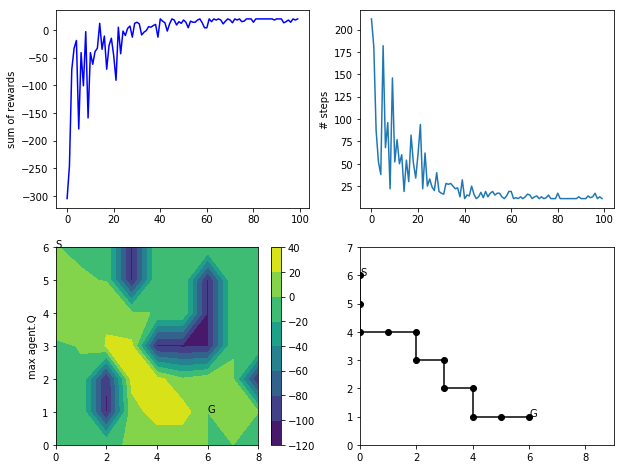

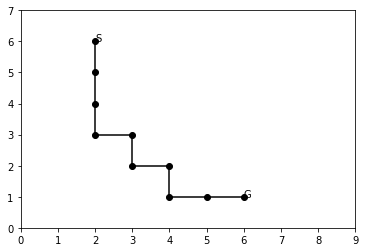

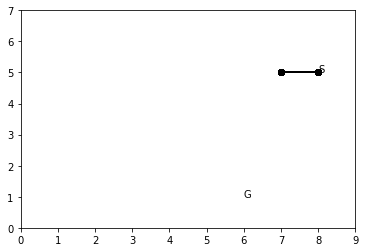

In [18]:
agent = RLAgent_Grid(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha= .1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

plot_train(agent, rtrace, steps, trace, start)
plt.show()

test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show()

test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show();


The first change I made to the parameters was adjusting the epsilon from .1 to .5. I did this because epsilon represents the chance the agent will make a nongreedy action, indicating exploration. I have increased the epsilon value from .1 to .5. <br>

As we can see from our contour plot we have slightly increased the agent’s knowledge of each states expected reward (Q-values), the yellow area has expanded. If we look at the trajectory plot we can see we also have relatively destabilized the agent, causing it not to follow the optimal path due to more random actions being taken. We can also observe this in the number of steps it takes to find the goal (takes 50 or more steps now to find the goal). Still, the agent can’t seem to find the goal when starting from [1,8] that often.

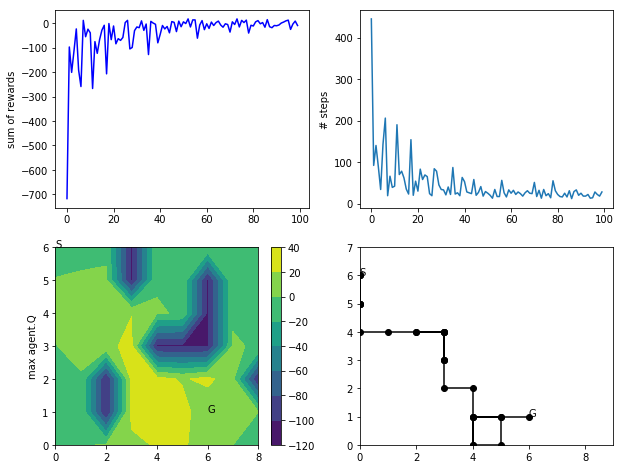

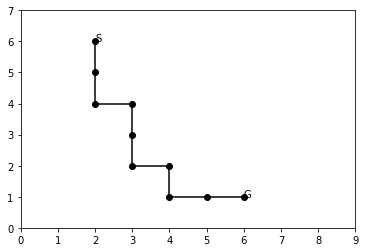

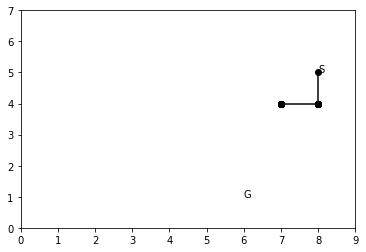

In [19]:
agent = RLAgent_Grid(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha= .1, 
                                   epsilon=0.5, 
                                   maxiter=100, 
                                   maxstep=1000)

plot_train(agent, rtrace, steps, trace, start)
plt.show()

test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show()

test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show();

The next change I made was to the maxiter parameter. By greatly increasing the number of iterations the agent has to learn the policy (maxiter) I allow the agent to gain more experience. I have increased maxiter from 100 to 5000 

As we can see the expected state-action values have become far more precise and the yellow area on the contour plot has been vastly increased (knownledge of q-values increased). If we now observe the trajectory from starting position [1,8] it can now find the path to the goal node the majority of the time (a successful trajectory depends on the how well the agent learned the policy in the train() function). Although we have explored more and are have finally begun consistently reaching the goal from the [1,8] starting location. We have again slightly decreased stability of the agent(this is seen in the variance in the sum of rewards and steps taken graphs). I believe with more complex algorithms like epsilon decay the balance between exploration and exploitation might greatly improve.

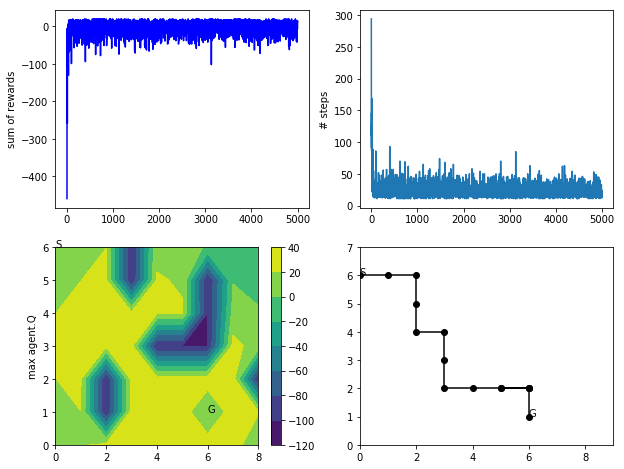

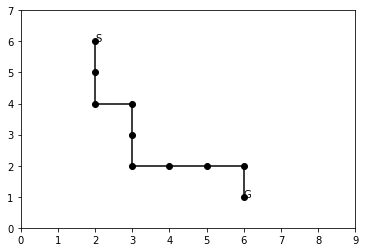

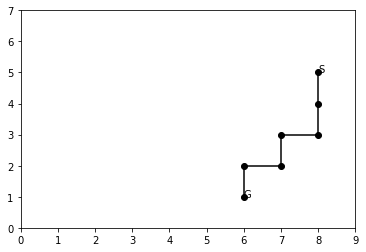

In [14]:
agent = RLAgent_Grid(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha= .1, 
                                   epsilon=0.5, 
                                   maxiter=5000, 
                                   maxstep=1000)

plot_train(agent, rtrace, steps, trace, start)
plt.show()

test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show()

test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show();


The last change I made to my parameters was changing the learning rate (alpha). By increasing the learning rate, the algorithm allows for a larger portion of the state-action values to be capture at one time-step. Normally with a learning rate of .1 only 10% of the TD error value only is captured per visit to a state-action pair. Now that I have increased the alpha from .1 to 1 - the whole TD error value is now captured.

As we can see in the contour plot, the expected value for each state-action pair has been vastly increased, the yellow area has greatly expanded. Most of the other plots have remained the same with slight increases to the variance in the number of steps needed and total sum of reward per episode. Therefore, increasing my alpha does not seem to have vastly increased the destabilization of my agent, compared with previous changes. The agent rarely seems to not find the goal node now. I believe I have achieved my goal of exploring the environment enough to find the goal when starting at drastically different start locations. We can also observe a completely different starting location finding the way to the goal. Thus proving that the agent can almost always find the goal location from any starting position.

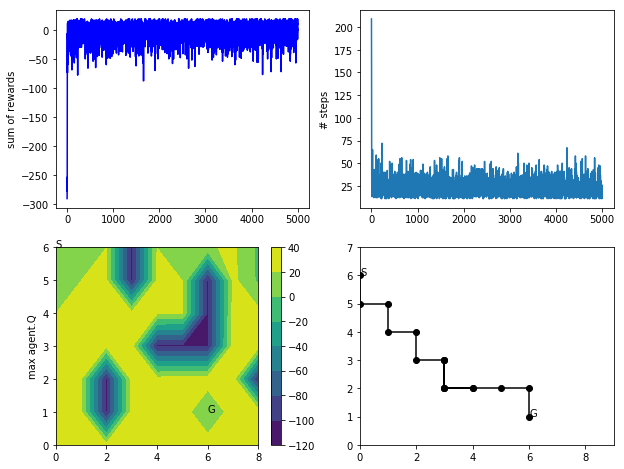

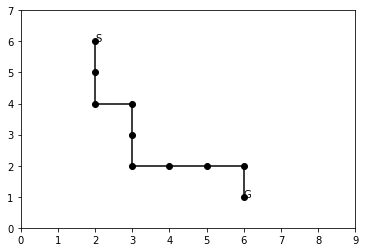

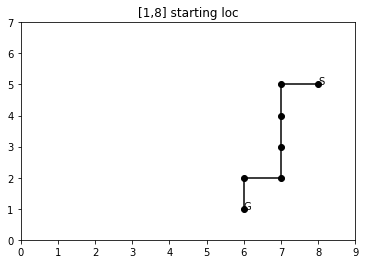

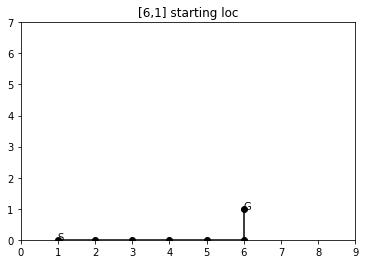

In [21]:
agent = RLAgent_Grid(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha= 1, 
                                   epsilon=0.5, 
                                   maxiter=5000, 
                                   maxstep=1000)

plot_train(agent, rtrace, steps, trace, start)
plt.show()

test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show()

test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.title("[1,8] starting loc")
plt.show();


test_start = [6,1]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.title("[6,1] starting loc")
plt.show();

### Training and Testing with Poker

Unlike the Gridworld problem I do not have a specific goal other than win more games and lose fewer games. Sadly, it is hard to tell if my parameter changes are doing anything due to how extremely sparse the Poker problems q-table is. The change with the biggest impact on the game has nothing to do with parameters though. This change is simply initializing the q-table with random values instead of zeros. My agent’s performance is then based on how well the values are randomized not what it has learned. In order to make up for this I’ll see if increasing the maxiter (number of games trained on) can improve my agent’s performance from a random like policy to something more learned. My starting maxiter will be 10,000 games. At this mark my agent seems to win consistently about 50% of the games played. If we look at the bar graph representing the 500 test games played, we can see this holds true. We can also see that most of my reward accumulated through each game is at or above 20. This may indicate higher reward is equal to wins and lower reward is equal to loses with some exception area (maybe 20-30 total reward)

It is important to note that I will be using a seed in order to judge my parameters effects and cancel out the effects of different random initializations take place at the start training.

In [22]:
%%capture
RLpoker_agent = RLAgent_Poker(2, 10, seed=2)
RLpoker_agent.train(gamma=.99, alpha=.1, epsilon=.2, maxiter=10000)

In [25]:
%%capture
test_reward, test_wins = RLpoker_agent.test(maxiter=500)

Loses/Wins: [230 270]


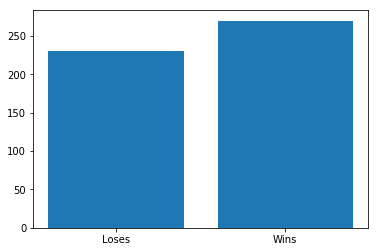

<function matplotlib.pyplot.show>

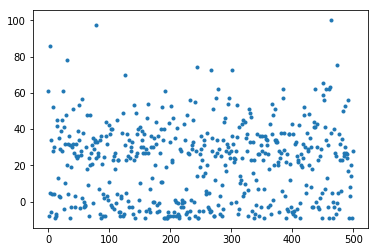

In [26]:
outcome = np.unique(test_wins, return_counts=True)[1]
x = np.arange(2)
print("Loses/Wins:", outcome)

plt.bar(x,outcome)
plt.xticks(x, ("Loses", "Wins"))
plt.show()

plt.plot(test_reward, '.')
plt.show

To confirm my suspicion about the maxiter being the only significant parameter, due to sparsity of the table, I have tried increasing the alpha to see if there was any significant impact, from .1 to 1. As it turns out there was almost not impact. If we look at the win/loses they remained about the same and so did the total reward plot (all within the margines of variance +- 10 wins). This quick test is enough to focus my attention on the maxiter parameter only, I will revert alpha back to .1. 

In [27]:
%%capture
RLpoker_agent = RLAgent_Poker(2, 10, seed=2)
RLpoker_agent.train(gamma=.99, alpha=1, epsilon=.2, maxiter=10000)

In [28]:
%%capture
test_reward, test_wins = RLpoker_agent.test(maxiter=500);

Loses/Wins: [234 266]


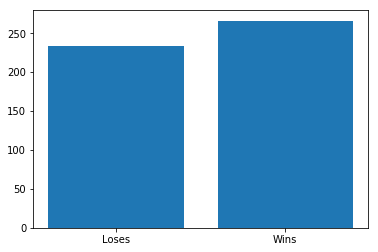

<function matplotlib.pyplot.show>

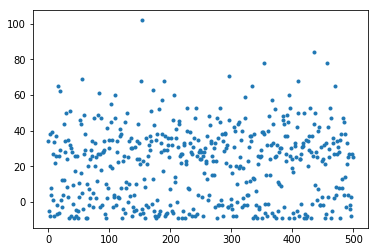

In [29]:
outcome = np.unique(test_wins, return_counts=True)[1]
x = np.arange(2)
print("Loses/Wins:", outcome)

plt.bar(x,outcome)
plt.xticks(x, ("Loses", "Wins"))
plt.show()

plt.plot(test_reward, '.')
plt.show

Next, I will try increasing the maxiter to 20,000 games to see if doubling the games played significantly increases performance or not. As we can see our wins only slightly increased even though we doubled the amount of games played, seen via that bar graph. We can also see that the total reward did not change signifcantly either. This can be attributed to sparsity of the table and makes me wary of increasing the number of episodes due to the insignificant improvement. The time-learning payoff just doesn’t seem worth doubling the maxiter again. Therefore, I will stop my experimentation here and conclude that q-tables are not the best method for the Poker problem due to sparse updates.

In [30]:
%%capture
RLpoker_agent = RLAgent_Poker(2, 10, seed=2)
RLpoker_agent.train(gamma=.99, alpha=.1, epsilon=.2, maxiter=20000)

In [31]:
%%capture
test_reward, test_wins = RLpoker_agent.test(maxiter=500);

Loses/Wins: [222 278]


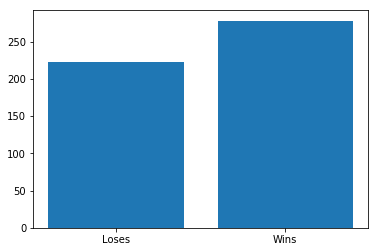

<function matplotlib.pyplot.show>

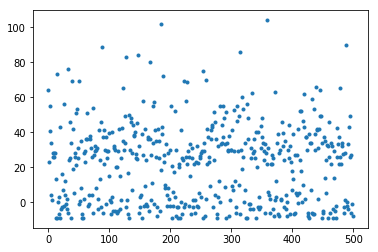

In [32]:
outcome = np.unique(test_wins, return_counts=True)[1]
x = np.arange(2)
print("Loses/Wins:", outcome)

plt.bar(x,outcome)
plt.xticks(x, ("Loses", "Wins"))
plt.show()

plt.plot(test_reward, '.')
plt.show

In [62]:
RLpoker_agent = RLAgent_Poker(2, 10, file='qtable.npy', seed=2)
RLpoker_agent.train(gamma=.99, alpha=.1, epsilon=.2, maxiter=400000)

Loading: qtable.npy
Q-table Shape: (21, 4, 8, 13, 21, 4)


In [63]:
%%capture
test_reward, test_wins = RLpoker_agent.test(maxiter=1000); # add 3rd 

Loses/Wins: [476 524]


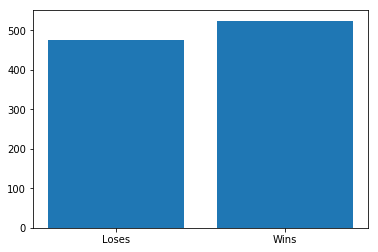

<function matplotlib.pyplot.show>

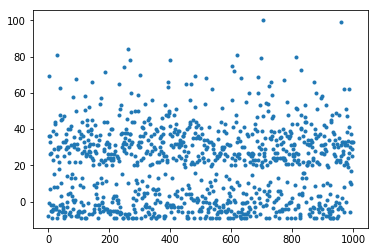

In [64]:
outcome = np.unique(test_wins, return_counts=True)[1]
x = np.arange(2)
print("Loses/Wins:", outcome)

plt.bar(x,outcome)
plt.xticks(x, ("Loses", "Wins"))
plt.show()

plt.plot(test_reward, '.')
plt.show

## Final Thoughts

In all I believe the Gridworld problem was the most successful and allowed for the most parameter experimentation. On the other had the Poker problem just simply doesn't seem suited for q-tables but more so function approximation. Due to my limited computing power I had to stop around 20000 samples for the poker problem which even then barely saw any improvement. Lastly, for the poker problem I am rather skeptical about the 50-50 win/lose. It seems the main driving force behind having such a high win rate is the random initialization and not the learning (since q-table is so spares). I attempted but did not show a training session of 50,000 poker games in which I lost more games than I won. Due to the unexpected results and extremely long run time I did not try this again and reverted back to my previous 20,000 poker games.

# V. Conclusions

The main challenge this assignment presented was figuring out the state dimensions for the poker problem. I could understand the abstract state dimensions but the technical dimensions where very unclear and seemed to be rather dynamic depending on how each person initialized the game. More clarification and direction on this front would alleviate a great deal of confusion and therefore would make the poker problem easier to follow. Other than that, I rather enjoyed this assignment!

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
10 | Maze Problem | 
 | 5| Includes description of maze problem
 | 5| Explains the GridWorld
10 | Poker 
 | 5| Includes description of poker problem
 | 5| Explains the Poker
25 | Methods | 
 | 5| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 |10| Implementation of the selected approach
 | 5| explanation of the codes
45 | Results 
| 5| Reports the selected parameters for both problems. 
|20| Experimental outputs that show the choice of parameters. How do you choose them? (10 points per each problem)
|10| Output plots (5 for each)
|10| reading and analysis of learning results and plots (5 for each)
5 | Conclusions 
